#### Face Identity Classification
This example illustrates Model Inversion (MINV) attacks on a face identity classfier model. The classfier is trained on [Large-scale CelebA - Aligned&Cropped](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. Please ensure the following structure in the data folder:

directory_structure:

```
data/
    ├── private/          # Private dataset
    │   ├── identity_1/
    │   │   ├── instance_1.jpg
    │   │   ├── instance_2.jpg
    │   │   └── ...
    │   ├── identity_2/
    │   │   ├── instance_1.jpg
    │   │   ├── instance_2.jpg
    │   │   └── ...
    │   └── ...
    └── public/           # Public dataset
        ├── identity_1/
        │   ├── instance_1.jpg
        │   ├── instance_2.jpg
        │   └── ...
        ├── identity_2/
        │   ├── instance_1.jpg
        │   ├── instance_2.jpg
        │   └── ...
        └── ...      
```


To prepare data for this example:

1. Download CelebA images "img_align_celeba.zip" from this [URL](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ) 
2. Download CelebA identities "identity_CelebA.txt" from this [URL](https://drive.google.com/drive/folders/0B7EVK8r0v71pOC0wOVZlQnFfaGs?resourcekey=0-pEjrQoTrlbjZJO2UL8K_WQ)
3. Unzip "img_align_celeba.zip" and place /img_align_celeba folder in examples/minv/celebA/data/
4. Place "identity_CelebA.txt" in examples/minv/celebA/data/
5. In the cell below select n classes to use, and n_private classes as private, n - n_private will be public.
6. Run the cell below

After running this, img_align_celebA folder can be removed if desired.

In [1]:
# Description: This script partitions the CelebA dataset into public and private folders based on the identity of the person in the image.

import pandas as pd
import os
import shutil

# read img_align_celeba/identity_CelebA.txt
df = pd.read_csv('./data/identity_CelebA.txt', sep=' ', header=None)
df.columns = ['img', 'label']

# Parameters
n = 10177 # total number of classes to take, max 10177
n_private = 1000 # number of classes to be private, max 10177 and <= n. The rest will be public

# Create folders
os.makedirs('./data', exist_ok=True)
os.makedirs('./data/private', exist_ok=True)
os.makedirs('./data/public', exist_ok=True)

# Copy images to folders based on label
for i in range(1,n+1):
    if i <= n_private:
        # folder name should be 0-indexed
        # so we subtract 1 from the label
        os.makedirs('./data/private/' + str(i-1), exist_ok=True)
        for img in df[df['label'] == i]['img']:          
            shutil.copy('./data/img_align_celeba/' + img, './data/private/' + str(i-1) + '/' + img)
    else:
        os.makedirs('./data/public/' + str(i-1), exist_ok=True)
        for img in df[df['label'] == i]['img']:
            shutil.copy('./data/img_align_celeba/' + img, './data/public/' + str(i-1) + '/' + img)
    if i % 100 == 0:
        print(i / n * 100, 'percent copied')

0.9826078412105729 percent copied
1.9652156824211457 percent copied
2.9478235236317185 percent copied
3.9304313648422915 percent copied
4.913039206052864 percent copied
5.895647047263437 percent copied
6.87825488847401 percent copied
7.860862729684583 percent copied
8.843470570895155 percent copied
9.826078412105728 percent copied
10.808686253316303 percent copied
11.791294094526874 percent copied
12.773901935737447 percent copied
13.75650977694802 percent copied
14.739117618158593 percent copied
15.721725459369166 percent copied
16.704333300579737 percent copied
17.68694114179031 percent copied
18.669548983000883 percent copied
19.652156824211456 percent copied
20.634764665422033 percent copied
21.617372506632606 percent copied
22.599980347843175 percent copied
23.582588189053748 percent copied
24.56519603026432 percent copied
25.547803871474894 percent copied
26.53041171268547 percent copied
27.51301955389604 percent copied
28.495627395106617 percent copied
29.478235236317186 percent

# Train the target model

In [1]:
import os
import sys
import yaml

# Path to the dataset zip file
data_folder = "./data"


project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [ ]:
from examples.minv.celebA.utils.celebA_data import get_celebA_train_test_loader

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

train_loader, test_loader = get_celebA_train_test_loader(train_config)

num_classes = train_loader.dataset.dataset.get_classes()

Run this cell if you want to train the model, otherwise skip this and load it in cell below public loader

In [ ]:
from examples.minv.celebA.utils.resnet_model import ResNet18, ResNet50, ResNet152, VGG16
from examples.minv.celebA.utils.resnet_model import create_trained_model_and_metadata
# Get number of classes from the train_loader
num_classes = train_loader.dataset.dataset.get_classes()
print(num_classes)

import torch
# Create the model
model = ResNet18(num_classes=num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

# Load the model
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,train_loader,test_loader, train_config)

1000


Training Progress: 100%|██████████| 50/50 [32:35<00:00, 39.11s/it]


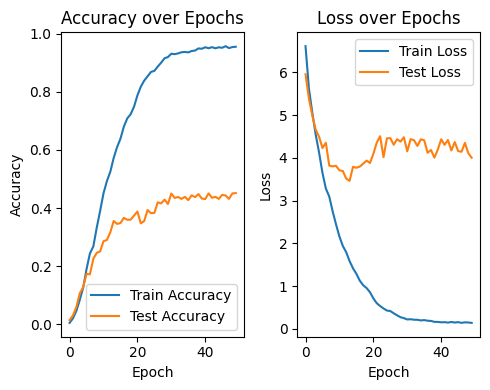

In [4]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Public loader
from examples.minv.celebA.utils.celebA_data import get_celebA_publicloader

pub_loader = get_celebA_publicloader(train_config)


Save data to ./data/celebA_public_data.pkl


In [ ]:
import torch
from torch.nn import functional as F
import numpy as np
from examples.minv.celebA.utils.resnet_model import ResNet152

# We have model_metadata.pkl and target_model.pkl. Load metadata and target model
# Load the model
num_classes = train_loader.dataset.dataset.get_classes()
model = ResNet152(num_classes=num_classes)
model.load_state_dict(torch.load('./target/target_model.pkl'))
model.eval()


Remove dis.pth and gen.pth if you want LeakPro to enter training loop. Number of iterations set to n_iter = 10 in this example.

Currently, result class is not setup.

In [3]:
from leakpro import LeakPro
from examples.minv.celebA.celebA_plgmi_handler import CelebA_InputHandler
config_path = "audit.yaml"


# Initialize the LeakPro object
leakpro = LeakPro(CelebA_InputHandler, config_path)

# Run the audit
results = leakpro.run_audit(return_results=True)


2025-04-10 10:02:39,880 INFO     Target model blueprint created from ResNet152 in utils/resnet152_model.py.
INFO:leakpro:Target model blueprint created from ResNet152 in utils/resnet152_model.py.
2025-04-10 10:02:39,937 INFO     Loaded target model metadata from ./target/model_metadata.pkl
INFO:leakpro:Loaded target model metadata from ./target/model_metadata.pkl
2025-04-10 10:02:42,483 INFO     Loaded target model from ./target
INFO:leakpro:Loaded target model from ./target
2025-04-10 10:02:51,206 INFO     Loaded public data from ./data/celebA_public_data.pkl
INFO:leakpro:Loaded public data from ./data/celebA_public_data.pkl
2025-04-10 10:02:58,800 INFO     Loaded private data from ./data/celebA_private_data.pkl
INFO:leakpro:Loaded private data from ./data/celebA_private_data.pkl
2025-04-10 10:02:58,802 INFO     Image extension initialized.
INFO:leakpro:Image extension initialized.
2025-04-10 10:02:58,812 INFO     MINV attack factory loaded.
INFO:leakpro:MINV attack factory loaded.
20

iteration: 00000/01000, loss gen: -0.073345, loss dis 1.829787, inv loss 7.311063, target acc 0.000000, time 10:04:54
iteration: 00010/01000, loss gen: 1.501039, loss dis 1.085391, inv loss 3.399533, target acc 0.000000, time 10:05:02
iteration: 00020/01000, loss gen: -0.491295, loss dis 1.033619, inv loss 3.795285, target acc 0.000000, time 10:05:10
iteration: 00030/01000, loss gen: 0.762793, loss dis 1.331703, inv loss 4.709433, target acc 0.000000, time 10:05:18
iteration: 00040/01000, loss gen: -0.597570, loss dis 1.981055, inv loss 3.443912, target acc 0.000000, time 10:05:25
iteration: 00050/01000, loss gen: 0.267707, loss dis 1.572512, inv loss 3.599462, target acc 0.000000, time 10:05:33
iteration: 00060/01000, loss gen: -1.709579, loss dis 2.745893, inv loss 3.736427, target acc 0.000000, time 10:05:40
iteration: 00070/01000, loss gen: 0.386828, loss dis 1.849558, inv loss 2.924927, target acc 0.000000, time 10:05:49
iteration: 00080/01000, loss gen: -0.014321, loss dis 1.7949

KeyboardInterrupt: 

Generate some sample images

In [ ]:
from examples.minv.celebA.utils.generator import ResNetGenerator
import torch
import matplotlib.pyplot as plt
import numpy as np

"""Generate example images using the trained generator"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# read config file
with open('audit.yaml', 'r') as file:
    config = yaml.safe_load(file)
    

dim_z = config['audit']['attack_list']['plgmi']['dim_z']

# Load generator and discriminator
gen = ResNetGenerator(num_classes=num_classes, dim_z=dim_z).to(device)
gen.load_state_dict(torch.load('gen.pth'))

# Generate images
gen.eval()

n_images = 4
z = torch.empty(n_images, dim_z, dtype=torch.float32, device=device).normal_()
y = torch.randint(0, num_classes, (n_images,)).to(device) # random labels
#y = torch.tensor([0, 1, 2, 3]).to(device) # fixed labels
print(y) 

with torch.no_grad():
    fake = gen(z, y)

# Normalize the generated images to the range [0, 1]
fake = (fake - fake.min()) / (fake.max() - fake.min())

# Plot the generated images
plt.figure(figsize=(10, 5))
for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(np.transpose(fake[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Printed tensor corresponds to the reconstructed identity in private dataset